## Problem Set 05
### AST 8110, Fall 2022
##### Tyler Barna

In [1]:
## Importing packages (some of these may not be useful)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import time
#bigstart = time.time()


import sys
import os
import astropy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import random

from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from numpy.linalg import norm ## to calculate magnitude of vector

from tqdm import tqdm
from scipy import meshgrid
from scipy.stats import binned_statistic as binstat
from scipy.integrate import quad, dblquad ## to integrate
from scipy.signal import argrelextrema as extrema 


## Set Seed
random.seed(8110)

### Problem 1

From class, we know that the absolute magnification is given by

$$
\begin{equation}
J = \left(A_1 + A_2\right) I = \frac{u^2 +2}{u\left( u^2 + 4\right)^{1/2}} I
\end{equation}
$$

for  $u=\frac{\beta}{\theta_E}$. $b$ is the distance of closest approach between the source and the lens. In problem one, $I=1$, so the magnification becomes simply

$$
\begin{equation}
J = \frac{u^2 +2}{u\left( u^2 + 4\right)^{1/2}}
\end{equation}
$$

The path of the source, $p$ is related to $\beta$, $b$, and $r_0$ as 

$$
\begin{equation}
\left(\beta + r_0 \right)^2 = b^2 + \left(p+ r_0\right)^2
\end{equation}
$$

solving for $\beta$ gives

$$
\begin{equation}
\beta = \sqrt{b^2 + \left(p+ r_0\right)^2} - r_0
\end{equation}
$$

If we evaluate in units of $\theta_E$, we can directly substitute $u$ with $\beta$. The magnification is then given by

$$
\begin{equation}
J = \frac{\beta^2 +2}{\beta\left( \beta^2 + 4\right)^{1/2}}
\end{equation}
$$

(a) $r_0=1.0$, $b=1.5$

(b) $r_0=0.2$, $b=1.5$

(c) $r_0=1.0$, $b=0.1$

(d) $r_0=0.2$, $b=0.1$

In [2]:
def lc(r0,b,p,dark=False):
    #u = np.sqrt
    beta = np.sqrt(b**2 + (p+r0)**2) - r0
    curve = (beta**2+2) / (beta* np.sqrt(beta**2 + 4))
    
    if dark:
        curve = curve * (1 - u*(1-np.sqrt(1-r0**2)))
    return np.abs(curve)

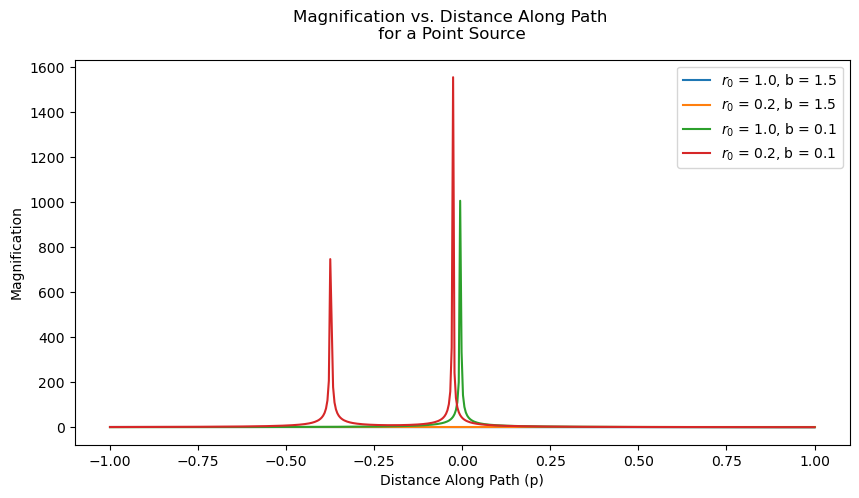

In [5]:
## define parameters
r0 = [1.0,0.2,1.0,0.2]
b = [1.5,1.5,0.1,0.1]
p = np.linspace(-1,1,500)

## plot the lightcurves
fig, ax = plt.subplots(1,1,figsize=(10,5))

for r0, b in zip(r0,b):
    sns.lineplot(x=p, y=lc(r0=r0,b=b,p=p,dark=False),
                 label=r'$r_0$ = {}, b = {}'.format(r0,b), ax = ax)
fig.suptitle('Magnification vs. Distance Along Path\n for a Point Source')
ax.set_xlabel('Distance Along Path (p)')
ax.set_ylabel('Magnification')
plt.show();

### Problem 2

Modify to include limb darkening, given by

$$
\begin{equation}
I\left(r\right) \propto 1 - u \left(1- \sqrt{1-r^2}\right)
\end{equation}
$$